## Rate Test for CircularLIB Cells

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
from datetime import datetime

### 1 Choose model

In [2]:
dfn = pybamm.lithium_ion.DFN()
dfn.print_parameter_info()

┌───────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Parameter                                                 │ Type of parameter                                                                                                                                                                                           │
├───────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Maximum concentration in negative electrode [mol.m-3]     │ Parameter                                                                                                                             

#### 1.1 Add submodels
Here the wanted submodels are added

In [3]:
print("Own mechanical submodel is to be added")

Own mechanical submodel is to be added


### 2 Choose parameter and experiment
The parameter set contains all the characterstics of the tested cell

In [4]:
parameter_values = pybamm.ParameterValues("Chen2020_AH_VM_modified") #_AH_VM_modified

4.2238294803322605 0.08486754361269738


#### 2.1 Check electrode SOH of data set

In [5]:
param =pybamm.LithiumIonParameters()
Q_n = parameter_values.evaluate(param.n.Q_Li_init)
Q_p = parameter_values.evaluate(param.p.Q_Li_init)
Q_Li = parameter_values.evaluate(param.Q_Li_particles_init)
Q_p_init= parameter_values.evaluate(param.p.Q_init)
Q_n_init= parameter_values.evaluate(param.n.Q_init)
print("Initial lihthium ions [mol] in positive and negative electrode as well as overall: \n",Q_p,"\n",Q_n,"\n",Q_Li,"\n")
print("Overall capacity in the system: \n",Q_Li*pybamm.constants.F/3600) #mAh
# print((Q_Li - 1e-6 * Q_p) / Q_n)
# print((Q_Li - 1 * Q_n) / Q_p)
# print((Q_Li - 1 * Q_p) / Q_n)
# print((Q_Li - 1e-6 * Q_n) / Q_p)
check=pybamm.lithium_ion.get_min_max_stoichiometries(parameter_values)
print("min sto neg elec, max sto neg elect, min sto pos elec, max sto pos elec \n",check)


Initial lihthium ions [mol] in positive and negative electrode as well as overall: 
 2.6894195851626126 
 1.5840025211911322 
 4.273422106353745 

Overall capacity in the system: 
 114.53404200569197
min sto neg elec, max sto neg elect, min sto pos elec, max sto pos elec 
 [0.027417899651232647, 0.9662177812136695, 0.15697616583575816, 0.8505039668455255]


#### 2.1 Define experiment

In [6]:
C5_Rate_test = pybamm.Experiment(
    [
        ("Discharge at 0.2 C until 3.0 V",
        "Rest for 30 minutes",
        "Charge at 0.2 C until 4.2 V"
        ),
    ] * 1
) #for 1 hours or

### 3 Choose solver and simulate

In [7]:
fast_solver = pybamm.CasadiSolver(atol=1e-6, rtol=1e-6, mode="safe")
sim = pybamm.Simulation(dfn, parameter_values=parameter_values, experiment=C5_Rate_test, solver=fast_solver) #, experiment=C_Rate_test
sol=sim.solve(initial_soc=0.91) #initial_soc=0.5 ; calc_esoh=False

### 4 Show results

In [14]:
dfn.variables.search("X-averaged negative")
output_variables = ["X-averaged positive electrode potential [V]","Positive electrode open-circuit potential [V]", "Negative electrode potential [V]","Negative electrode open-circuit potential [V]" , "Terminal voltage [V]","Positive electrode stoichiometry","Negative electrode stoichiometry","Battery open-circuit voltage [V]","Current [A]","Positive particle concentration overpotential [V]","Negative electrode reaction overpotential [V]","Exchange current density [A.m-2]","Discharge capacity [A.h]","Electrolyte concentration [mol.m-3]","Electrolyte potential [V]"] #,"Cell thickness change [m]"
pybamm.dynamic_plot(sol, output_variables=output_variables, time_unit="seconds")

Results for 'X-averaged negative': ['Sum of x-averaged negative electrode electrolyte reaction source terms [A.m-3]', 'Sum of x-averaged negative electrode volumetric interfacial current densities [A.m-3]', 'X-averaged negative  lithium plating thickness [m]', 'X-averaged negative SEI concentration [mol.m-3]', 'X-averaged negative SEI on cracks concentration [mol.m-3]', 'X-averaged negative SEI on cracks thickness [m]', 'X-averaged negative SEI thickness [m]', 'X-averaged negative dead lithium concentration [mol.m-3]', 'X-averaged negative dead lithium thickness [m]', 'X-averaged negative electrode SEI film overpotential [V]', 'X-averaged negative electrode SEI interfacial current density [A.m-2]', 'X-averaged negative electrode SEI on cracks interfacial current density [A.m-2]', 'X-averaged negative electrode SEI on cracks volumetric interfacial current density [A.m-3]', 'X-averaged negative electrode SEI volumetric interfacial current density [A.m-3]', 'X-averaged negative electrode 

interactive(children=(FloatSlider(value=0.0, description='t', max=38131.99456964579, step=381.31994569645786),…

### 4.1 Voltage analysis

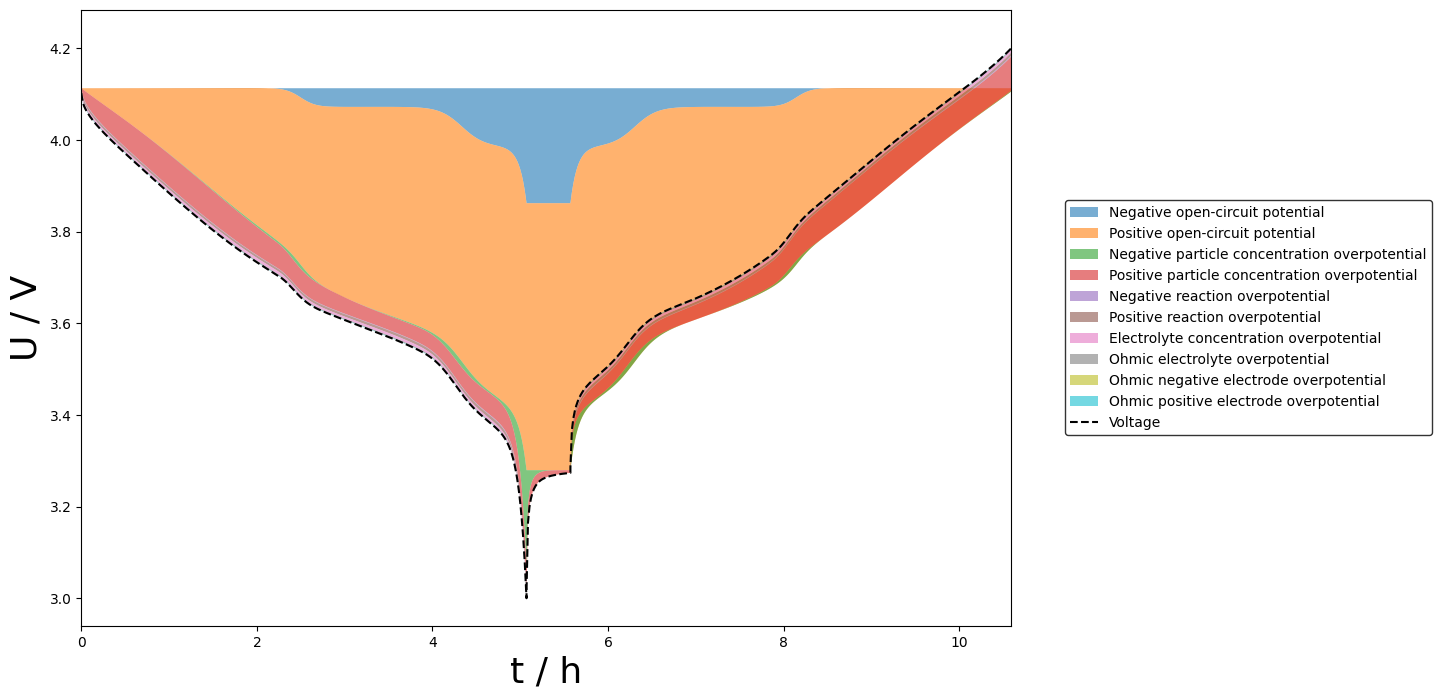

In [9]:
fig,ax1 = plt.subplots()
fig.set_size_inches(12,8)
pybamm.plot_voltage_components(sol,ax=ax1,split_by_electrode=True)
plt.xlabel("t / h", fontsize=26)
plt.ylabel("U / V", fontsize=26)
# xpoints = np.array([1, 8])
# ypoints = np.array([3, 10])
# plt.plot(xpoints, ypoints)
plt.rcParams.update({'font.size': 18})
date=datetime.now()
today=date.strftime("%Y%m%d")

### 5 Export data for further analysis

In [17]:
path_csv=pathlib.PureWindowsPath('Y:/07_Experimente_und_Messdaten/Projekte/BLB Pouch_Gold reference/Modelled_data/',today+"_CircularLIB_Set_C5"+".csv")
path_mat=pathlib.PureWindowsPath('Y:/07_Experimente_und_Messdaten/Projekte/BLB Pouch_Gold reference/Modelled_data/',today+"_CircularLIB_Set_C5"+".mat")

sol.save_data(path_csv, ["Time [s]", "Current [A]", "Terminal voltage [V]", "X-averaged positive electrode potential [V]", "X-averaged negative electrode open-circuit potential [V]"], to_format="csv") # operation voltages in graphite are averaged not meaningful (due to high conductivity?)
sol.save_data(path_mat, ["Time [s]", "Current [A]", "Terminal voltage [V]", "X-averaged positive electrode potential [V]", "X-averaged negative electrode open-circuit potential [V]"], to_format="matlab",
              short_names={"Time [s]": "t", "Current [A]": "I", "Terminal voltage [V]": "V", "X-averaged positive electrode potential [V]": "V_we", "X-averaged negative electrode open-circuit potential [V]": "V_ce"})
